In [ ]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 1.4MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.0.5-cp36-none-any.whl size=4118721 sha256=4931ed074bb72784220ee7cd7426aec55eb26f0a69b88ab29cab11b8fcc3eb7a
  Stored in directory: /root/.cache/pip/wheels/6c/8a/08/4a784957da9f3c2b4839b4986be2fba2a481877318948be52c
Successfully built japanize-matplotlib


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from fastprogress import progress_bar as pb
import japanize_matplotlib

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
STOCKPRICE_FILEPATH_FMT = 's3://fin-app/stockprice/2020/{code}.csv'

In [ ]:
df_stocklist = pd.read_csv('s3://fin-app/stocklist/stocklist.csv')

In [ ]:
df_stocklist.head()

,銘柄コード,銘柄名,市場名,業種分類,単元株数,日経225採用銘柄
0,1301,(株)極洋,東証1部,水産・農林業,100,NaN
1,1332,日本水産(株),東証1部,水産・農林業,100,1.0
2,1333,マルハニチロ(株),東証1部,水産・農林業,100,1.0
3,1352,(株)ホウスイ,東証1部,卸売業,100,NaN
4,1376,カネコ種苗(株),東証1部,水産・農林業,100,NaN


In [ ]:
codes = df_stocklist['銘柄コード'].unique()

In [ ]:
codes

array([1301, 1332, 1333, ..., 9995, 9996, 9997])

In [ ]:
df_dict = {}
skipped_code = []

for code in pb(codes):
    try:
        df_dict[code] = pd.read_csv(STOCKPRICE_FILEPATH_FMT.format(code=code))
    except Exception:
        skipped_code.append(code)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
 for code, df in pb(df_dict.items()):
     df.to_csv(f'/content/drive/My Drive/data/stockprice/2020/{code}.csv', index=None)

In [ ]:
 for code, df in df_dict.items():
    df_dict[code]['日付'] = pd.to_datetime(df_dict[code]['日付'])
    df_dict[code].set_index('日付', inplace=True)

In [ ]:
len(skipped_code)

52

In [ ]:
valid_codes = list(df_dict.keys())

In [ ]:
df_dict[1301]

,始値,高値,安値,終値,出来高,終値調整値
日付,,,,,,
2020-01-06,2860,2873,2851,2862,25700,2862
2020-01-07,2864,2907,2864,2898,30300,2898
2020-01-08,2892,2908,2855,2903,30300,2903
2020-01-09,2911,2949,2911,2933,31500,2933
2020-01-10,2940,2942,2924,2932,11600,2932
...,...,...,...,...,...,...
2020-04-02,2467,2539,2446,2512,44400,2512
2020-04-03,2481,2530,2456,2496,31300,2496
2020-04-06,2450,2527,2450,2504,29600,2504


In [ ]:
CHANGE_RATE_DATES = [
    ['2020-01-01', '2020-04-08'],
    ['2020-02-01', '2020-03-01'],
    ['2020-03-01', '2020-04-08'],
    ['2020-02-01', '2020-04-08'],
    ['2020-02-15', '2020-03-15'],
]

In [ ]:
change_rates = {}

for dt_start, dt_end in pb(CHANGE_RATE_DATES):
    dt_tag = dt_start.replace('-', '') + '_' + dt_end.replace('-', '')
    dt_start = datetime.strptime(dt_start, "%Y-%m-%d")
    dt_end = datetime.strptime(dt_end, "%Y-%m-%d")

    crs = []
    for code in valid_codes:
        df_price = df_dict[code]

        dt_min = df_price[df_price.index >= dt_start].index.min()
        dt_max = df_price[df_price.index <= dt_end].index.max()

        if abs((dt_min - dt_start).days) > 7 or abs((dt_max - dt_end).days) > 7:
            crs.append(None)
            continue
        
        cr = (df_price.loc[dt_max]['終値'] - df_price.loc[dt_min]['終値']) / df_price.loc[dt_min]['終値']
        crs.append(cr)
    
    change_rates[dt_tag] = crs

In [ ]:
change_rates['code'] = valid_codes

In [ ]:
df_change_rate = pd.DataFrame(change_rates)

In [ ]:
df_change_rate

,20200101_20200408,20200201_20200301,20200301_20200408,20200201_20200408,20200215_20200315,code
0,-0.092593,-0.087080,-0.023684,-0.080708,-0.195148,1301
1,-0.252782,-0.142617,-0.111531,-0.211409,-0.332792,1332
2,-0.149814,-0.144260,-0.007809,-0.136329,-0.265266,1333
3,-0.186927,-0.153680,-0.074413,-0.232684,-0.259681,1352
4,0.035714,-0.099530,0.216443,0.136364,-0.331849,1376
...,...,...,...,...,...,...
3809,-0.069412,-0.134399,0.040789,-0.063351,-0.271862,9993
3810,-0.106561,-0.070302,-0.057594,-0.085624,-0.154644,9994
3811,-0.155361,-0.101124,-0.063107,-0.132584,-0.186364,9995
3812,-0.126870,-0.045906,-0.075997,-0.094913,-0.146951,9996


In [ ]:
df_change_rate.isnull().sum()

20200101_20200408      24
20200201_20200301       8
20200301_20200408      15
20200201_20200408      21
20200215_20200315       9
code                    0
銘柄コード                   0
銘柄名                     0
市場名                    21
業種分類                    0
単元株数                    0
日経225採用銘柄            3589
dtype: int64

In [ ]:
df_change_rate.dropna(how='any', inplace=True)

In [ ]:
df_change_rate = pd.merge(df_change_rate, df_stocklist, how='left', left_on='code', right_on='銘柄コード')

In [ ]:
df_change_rate

,20200101_20200408,20200201_20200301,20200301_20200408,20200201_20200408,20200215_20200315,code,銘柄コード,銘柄名,市場名,業種分類,単元株数,日経225採用銘柄
0,-0.092593,-0.087080,-0.023684,-0.080708,-0.195148,1301,1301,(株)極洋,東証1部,水産・農林業,100,NaN
1,-0.252782,-0.142617,-0.111531,-0.211409,-0.332792,1332,1332,日本水産(株),東証1部,水産・農林業,100,1.0
2,-0.149814,-0.144260,-0.007809,-0.136329,-0.265266,1333,1333,マルハニチロ(株),東証1部,水産・農林業,100,1.0
3,-0.186927,-0.153680,-0.074413,-0.232684,-0.259681,1352,1352,(株)ホウスイ,東証1部,卸売業,100,NaN
4,0.035714,-0.099530,0.216443,0.136364,-0.331849,1376,1376,カネコ種苗(株),東証1部,水産・農林業,100,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3776,-0.069412,-0.134399,0.040789,-0.063351,-0.271862,9993,9993,(株)ヤマザワ,東証1部,小売業,100,NaN
3777,-0.106561,-0.070302,-0.057594,-0.085624,-0.154644,9994,9994,(株)やまや,東証1部,小売業,100,NaN
3778,-0.155361,-0.101124,-0.063107,-0.132584,-0.186364,9995,9995,(株)グローセル,東証1部,卸売業,100,NaN
3779,-0.126870,-0.045906,-0.075997,-0.094913,-0.146951,9996,9996,(株)サトー商会,東証JQS,卸売業,100,NaN


In [ ]:
df_change_rate.sort_values(by='20200101_20200408')

,20200101_20200408,20200201_20200301,20200301_20200408,20200201_20200408,20200215_20200315,code,銘柄コード,銘柄名,市場名,業種分類,単元株数,日経225採用銘柄
885,-0.821235,-0.179979,-0.795285,-0.824281,-0.339708,3563,3563,(株)スシローグローバルホールディングス,東証1部,小売業,100,NaN
3590,-0.816138,-0.348227,-0.670284,-0.773759,-0.511530,9625,9625,(株)セレスポ,東証JQS,サービス業,100,NaN
212,-0.781732,-0.627078,-0.362319,-0.766841,-0.758027,2157,2157,(株)コシダカホールディングス,東証1部,サービス業,100,NaN
3546,-0.776409,-0.064698,-0.757670,-0.760056,-0.256131,9470,9470,(株)学研ホールディングス,東証1部,情報・通信,100,NaN
676,-0.736292,-0.293118,-0.450490,-0.570943,-0.466964,3223,3223,(株)エスエルディー,東証JQS,小売業,100,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1367,1.085142,0.450000,0.236634,0.921538,-0.056800,4488,4488,ＡＩ ｉｎｓｉｄｅ(株),NaN,情報・通信,100,NaN
1330,1.166667,0.087369,0.441062,0.753086,0.049715,4434,4434,(株)サーバーワークス,マザーズ,情報・通信,100,NaN
2902,1.282091,0.877193,-0.008350,0.860276,-0.018036,7891,7891,日本ユピカ(株),東証JQS,化学,100,NaN
1404,1.790909,-0.403071,0.025042,-0.410749,-0.663462,4558,4558,(株)中京医薬品,東証JQS,医薬品,100,NaN


In [ ]:
df_change_rate['業種分類'].value_counts()

情報・通信       470
サービス業       466
小売業         355
卸売業         322
電気機器        244
機械          229
化学          211
建設業         162
不動産業        136
食料品         126
その他製品       108
輸送用機器        95
金属製品         92
銀行業          88
医薬品          68
陸運業          65
REIT銘柄一覧     63
ガラス・土石製品     58
繊維製品         55
精密機器         52
鉄鋼           45
証券業          40
倉庫・運輸関連業     35
その他金融業       34
非鉄金属         33
パルプ・紙        26
電気・ガス業       24
ゴム製品         19
保険業          14
海運業          13
水産・農林業       11
石油・石炭製品      11
鉱業            6
空運業           5
Name: 業種分類, dtype: int64

In [ ]:
df_change_rate.groupby(['業種分類']).mean().sort_values(by='20200201_20200408')

,20200101_20200408,20200201_20200301,20200301_20200408,20200201_20200408,20200215_20200315,code,銘柄コード,日経225採用銘柄
業種分類,,,,,,,,
不動産業,-0.332955,-0.175007,-0.200185,-0.311142,-0.348201,5895.492647,5895.492647,1.0
REIT銘柄一覧,-0.296272,-0.091020,-0.240260,-0.308364,-0.317021,5488.269841,5488.269841,NaN
サービス業,-0.317573,-0.188181,-0.175515,-0.296540,-0.353201,5559.169528,5559.169528,1.0
空運業,-0.281095,-0.195494,-0.163357,-0.287364,-0.308261,9214.800000,9214.800000,1.0
輸送用機器,-0.304450,-0.119866,-0.185735,-0.272358,-0.288831,7051.873684,7051.873684,1.0
非鉄金属,-0.301338,-0.134479,-0.166437,-0.259849,-0.326215,5636.060606,5636.060606,1.0
その他金融業,-0.264699,-0.129731,-0.181629,-0.259239,-0.318822,7914.088235,7914.088235,1.0
鉄鋼,-0.273400,-0.144507,-0.139369,-0.245676,-0.318557,5586.666667,5586.666667,1.0
ゴム製品,-0.270691,-0.121297,-0.158506,-0.241508,-0.285866,5153.263158,5153.263158,1.0


In [ ]:
df_change_rate.groupby(['業種分類']).mean().sort_values(by='20200301_20200408')

,20200101_20200408,20200201_20200301,20200301_20200408,20200201_20200408,20200215_20200315,code,銘柄コード,日経225採用銘柄
業種分類,,,,,,,,
REIT銘柄一覧,-0.296272,-0.091020,-0.240260,-0.308364,-0.317021,5488.269841,5488.269841,NaN
不動産業,-0.332955,-0.175007,-0.200185,-0.311142,-0.348201,5895.492647,5895.492647,1.0
輸送用機器,-0.304450,-0.119866,-0.185735,-0.272358,-0.288831,7051.873684,7051.873684,1.0
その他金融業,-0.264699,-0.129731,-0.181629,-0.259239,-0.318822,7914.088235,7914.088235,1.0
サービス業,-0.317573,-0.188181,-0.175515,-0.296540,-0.353201,5559.169528,5559.169528,1.0
非鉄金属,-0.301338,-0.134479,-0.166437,-0.259849,-0.326215,5636.060606,5636.060606,1.0
空運業,-0.281095,-0.195494,-0.163357,-0.287364,-0.308261,9214.800000,9214.800000,1.0
ゴム製品,-0.270691,-0.121297,-0.158506,-0.241508,-0.285866,5153.263158,5153.263158,1.0
証券業,-0.221604,-0.127748,-0.143391,-0.229026,-0.309719,8276.175000,8276.175000,1.0


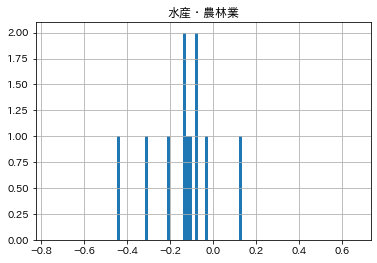

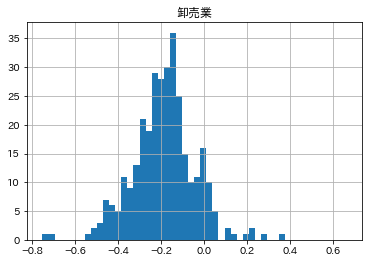

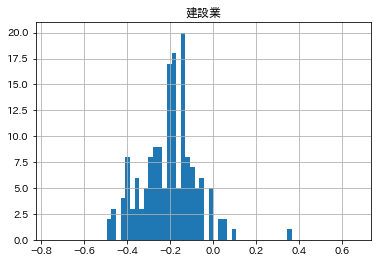

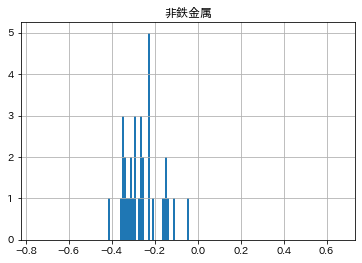

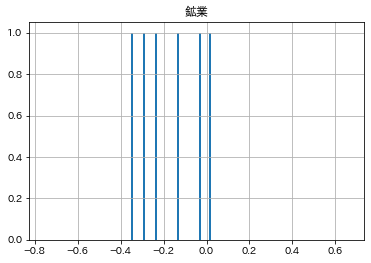

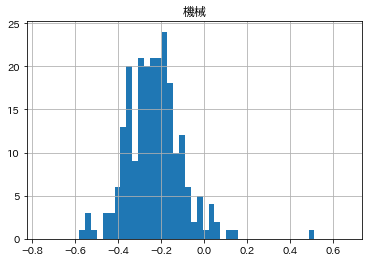

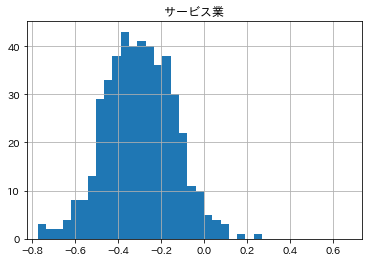

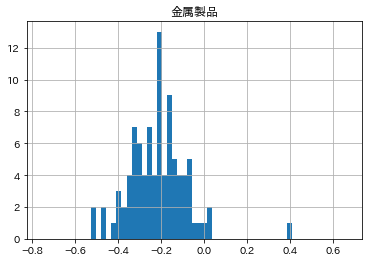

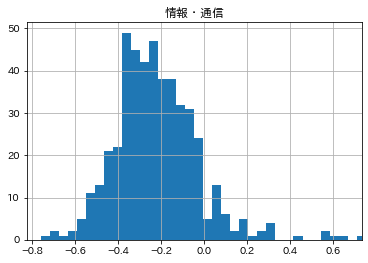

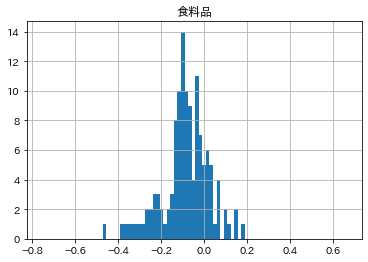

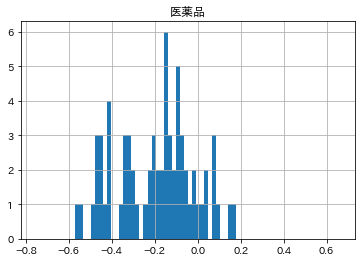

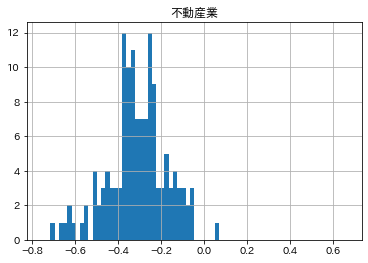

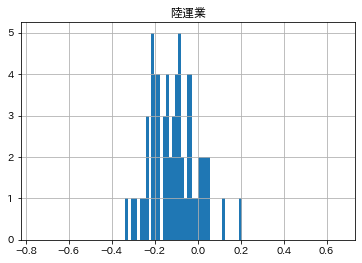

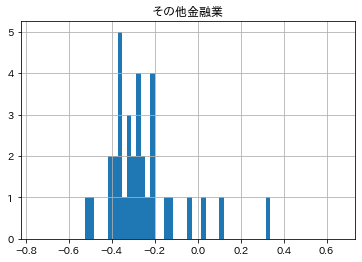

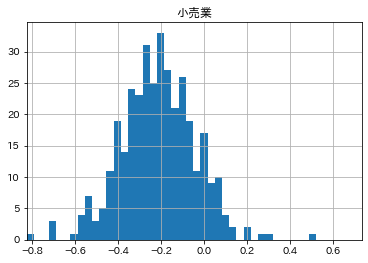

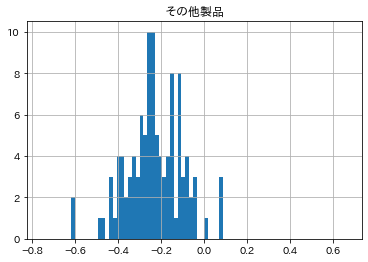

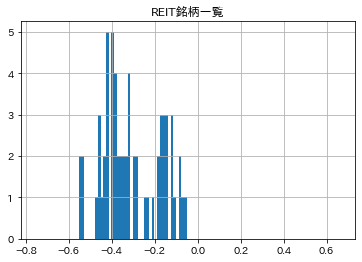

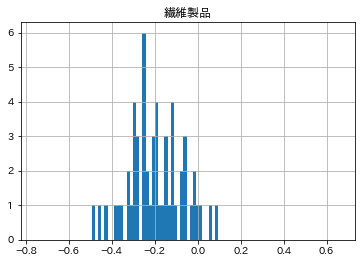

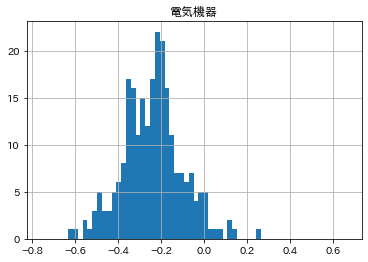

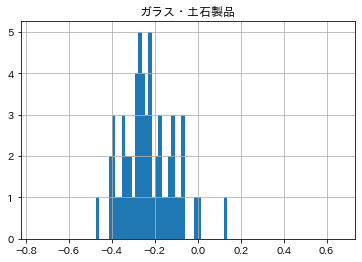

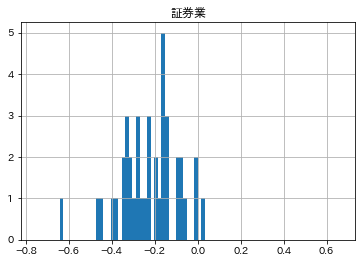

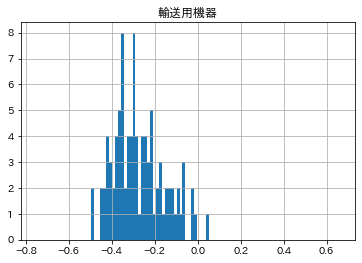

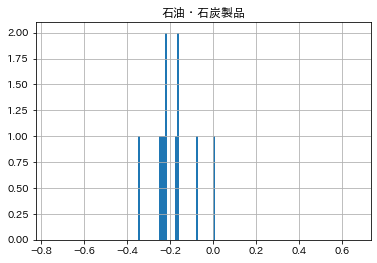

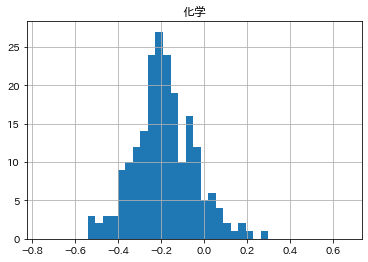

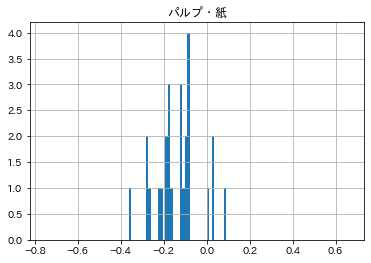

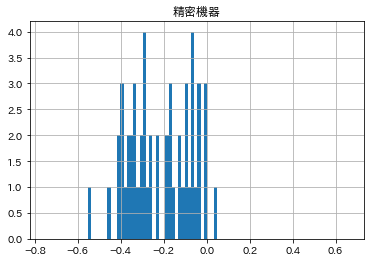

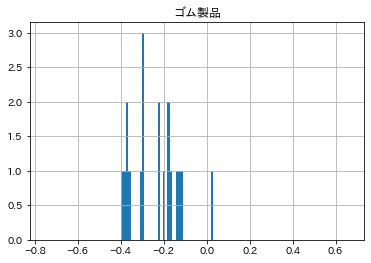

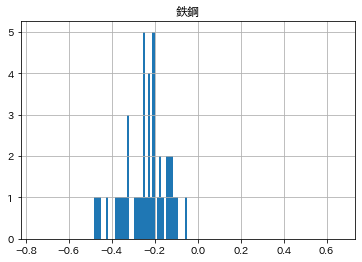

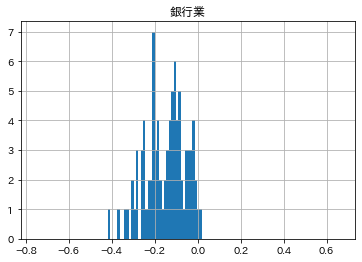

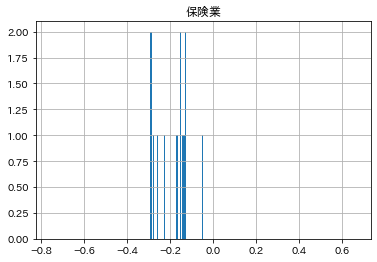

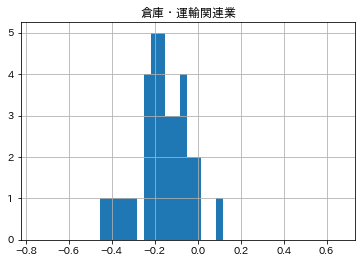

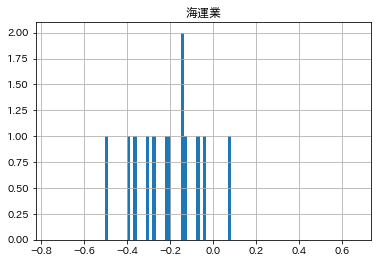

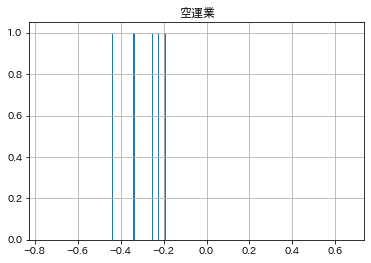

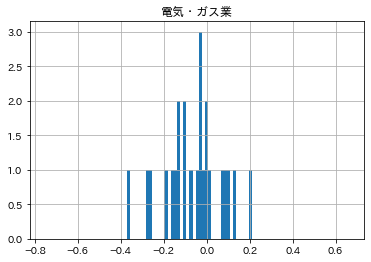

In [ ]:
for industry in df_change_rate['業種分類'].unique():
    df_change_rate[df_change_rate['業種分類'] == industry]['20200201_20200408'].hist(bins=40)
    plt.title(industry)
    plt.xlim(df_change_rate['20200201_20200408'].min(), df_change_rate['20200301_20200408'].max())
    plt.show()

In [ ]:
pd.set_option('display.max_rows', 50)

In [ ]:
df_change_rate.sort_values(by='20200301_20200408')

,20200101_20200408,20200201_20200301,20200301_20200408,20200201_20200408,20200215_20200315,code,銘柄コード,銘柄名,市場名,業種分類,単元株数,日経225採用銘柄
885,-0.821235,-0.179979,-0.795285,-0.824281,-0.339708,3563,3563,(株)スシローグローバルホールディングス,東証1部,小売業,100,NaN
531,-0.653595,0.196092,-0.783673,-0.714286,-0.195941,2970,2970,(株)グッドライフカンパニー,東証JQS,不動産業,100,NaN
3546,-0.776409,-0.064698,-0.757670,-0.760056,-0.256131,9470,9470,(株)学研ホールディングス,東証1部,情報・通信,100,NaN
910,-0.706376,-0.034743,-0.703611,-0.714804,-0.279661,3626,3626,ＴＩＳ(株),東証1部,情報・通信,100,NaN
2481,-0.686364,-0.282024,-0.672098,-0.742743,-0.416620,7033,7033,(株)マネジメントソリューションズ,東証1部,サービス業,100,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1330,1.166667,0.087369,0.441062,0.753086,0.049715,4434,4434,(株)サーバーワークス,マザーズ,情報・通信,100,NaN
3432,0.111762,-0.206724,0.444263,0.206724,-0.213270,9090,9090,(株)丸和運輸機関,東証1部,陸運業,100,NaN
954,0.581259,0.004304,0.565217,0.549498,0.129310,3681,3681,(株)ブイキューブ,東証1部,情報・通信,100,NaN
1406,0.124194,-0.362890,0.659524,0.144499,0.048043,4563,4563,アンジェス(株),マザーズ,医薬品,100,NaN


In [ ]:
df_change_rate.sort_values(by='20200201_20200408')

,20200101_20200408,20200201_20200301,20200301_20200408,20200201_20200408,20200215_20200315,code,銘柄コード,銘柄名,市場名,業種分類,単元株数,日経225採用銘柄
885,-0.821235,-0.179979,-0.795285,-0.824281,-0.339708,3563,3563,(株)スシローグローバルホールディングス,東証1部,小売業,100,NaN
3590,-0.816138,-0.348227,-0.670284,-0.773759,-0.511530,9625,9625,(株)セレスポ,東証JQS,サービス業,100,NaN
212,-0.781732,-0.627078,-0.362319,-0.766841,-0.758027,2157,2157,(株)コシダカホールディングス,東証1部,サービス業,100,NaN
3546,-0.776409,-0.064698,-0.757670,-0.760056,-0.256131,9470,9470,(株)学研ホールディングス,東証1部,情報・通信,100,NaN
2750,-0.734694,-0.466667,-0.573770,-0.752381,-0.744444,7612,7612,(株)Ｎｕｔｓ,東証JQS,卸売業,100,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1877,0.762322,0.091510,0.411404,0.773980,-0.210076,6034,6034,ＭＲＴ(株),マザーズ,サービス業,100,NaN
1359,0.800766,0.282132,0.293341,0.841693,0.029775,4480,4480,(株)メドレー,NaN,情報・通信,100,NaN
2902,1.282091,0.877193,-0.008350,0.860276,-0.018036,7891,7891,日本ユピカ(株),東証JQS,化学,100,NaN
3487,0.511986,0.678801,0.047450,0.890792,0.077586,9325,9325,ファイズホールディングス(株),東証1部,倉庫・運輸関連業,100,NaN
